In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
#Data Preparation
def prepare_data():
    # Load data
    customers_df = pd.read_csv('Customers.csv')
    transactions_df = pd.read_csv('Transactions.csv')
    products_df = pd.read_csv('Products.csv')
    
    # Convert dates
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    
    # Create customer features
    # Transaction-based features
    customer_transactions = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'Quantity': 'sum',
        'TotalValue': ['sum', 'mean', 'std']
    }).round(2)
    customer_transactions.columns = ['transaction_count', 'total_items', 
                                   'total_spend', 'avg_transaction', 'std_transaction']
    
    # Recency, Frequency, Monetary (RFM) features
    latest_date = transactions_df['TransactionDate'].max()
    recency = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    recency = (latest_date - recency).dt.days
    
    # Product category preferences
    transaction_products = pd.merge(transactions_df, products_df[['ProductID', 'Category']], 
                                  on='ProductID')
    category_preferences = pd.crosstab(transaction_products['CustomerID'], 
                                     transaction_products['Category'], normalize='index')
    
    # Region encoding
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')
    
    # Combine features
    features_df = pd.concat([
        customer_transactions,
        recency.to_frame('recency'),
        category_preferences,
        region_dummies
    ], axis=1).fillna(0)
    
    return features_df

In [3]:
#Clustering Analysis
def perform_clustering(features_df, n_clusters_range=range(2, 11)):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    
    # Store metrics
    metrics = []
    
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(scaled_features)
        
        db_index = davies_bouldin_score(scaled_features, clusters)
        silhouette = silhouette_score(scaled_features, clusters)
        
        metrics.append({
            'n_clusters': n_clusters,
            'db_index': db_index,
            'silhouette': silhouette,
            'inertia': kmeans.inertia_
        })
    
    return pd.DataFrame(metrics), scaled_features

In [4]:
#Visualization
def plot_clustering_metrics(metrics_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # DB Index
    ax1.plot(metrics_df['n_clusters'], metrics_df['db_index'], marker='o')
    ax1.set_title('Davies-Bouldin Index vs Number of Clusters')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Davies-Bouldin Index')
    ax1.grid(True)
    
    # Silhouette Score
    ax2.plot(metrics_df['n_clusters'], metrics_df['silhouette'], marker='o')
    ax2.set_title('Silhouette Score vs Number of Clusters')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_clusters(scaled_features, clusters, n_clusters):
    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(scaled_features)
    
    # Plot clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                         c=clusters, cmap='viridis')
    plt.title(f'Customer Segments ({n_clusters} clusters)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.show()

In [6]:
#Cluster Analysis
def analyze_clusters(features_df, clusters, n_clusters):
    features_df['Cluster'] = clusters
    
    cluster_analysis = features_df.groupby('Cluster').agg({
        'transaction_count': 'mean',
        'total_spend': 'mean',
        'avg_transaction': 'mean',
        'recency': 'mean'
    }).round(2)
    
    return cluster_analysis

In [7]:
# Main execution
features_df = prepare_data()
metrics_df, scaled_features = perform_clustering(features_df)

In [8]:
# Find optimal number of clusters
optimal_clusters = metrics_df.loc[metrics_df['db_index'].idxmin(), 'n_clusters']
print(f"\nOptimal number of clusters based on DB Index: {optimal_clusters}")
print("\nClustering Metrics:")
print(metrics_df.round(4))


Optimal number of clusters based on DB Index: 10

Clustering Metrics:
   n_clusters  db_index  silhouette    inertia
0           2    1.1006      0.4237  3182.5438
1           3    1.6168      0.3964  2918.4277
2           4    1.3746      0.4028  2461.9565
3           5    1.2254      0.5236  2010.1637
4           6    1.2447      0.4552  1818.7787
5           7    1.1755      0.4586  1641.9215
6           8    1.0177      0.5861  1177.2601
7           9    1.0044      0.5945  1013.9300
8          10    0.9791      0.5957   902.4655


In [9]:
# Perform final clustering with optimal number of clusters
final_kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42)
final_clusters = final_kmeans.fit_predict(scaled_features)

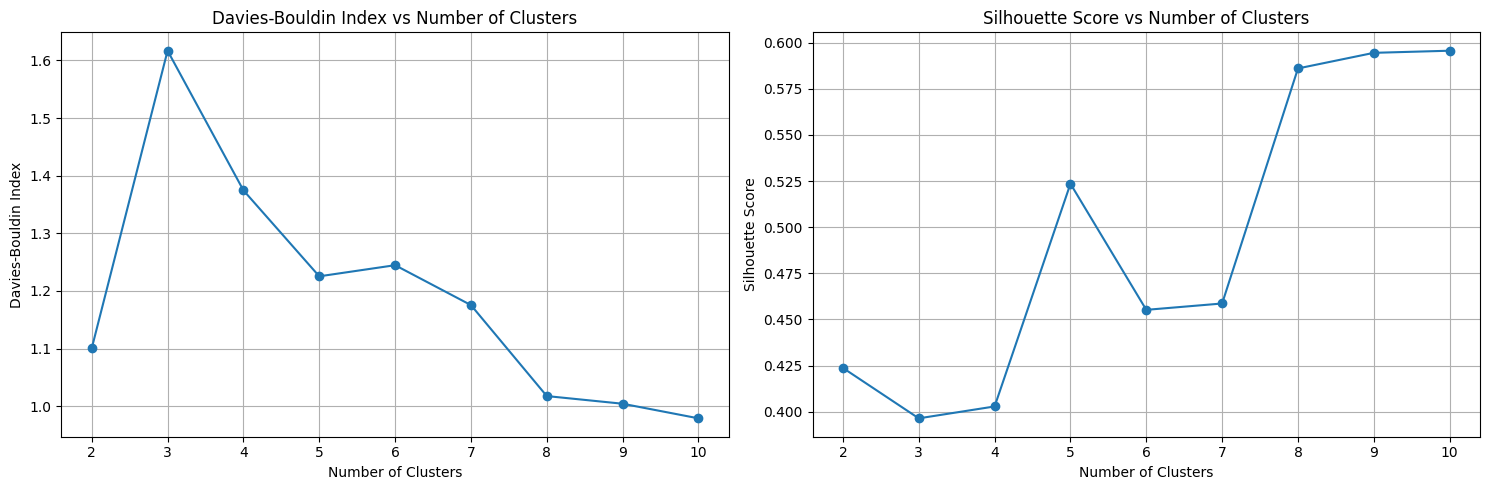

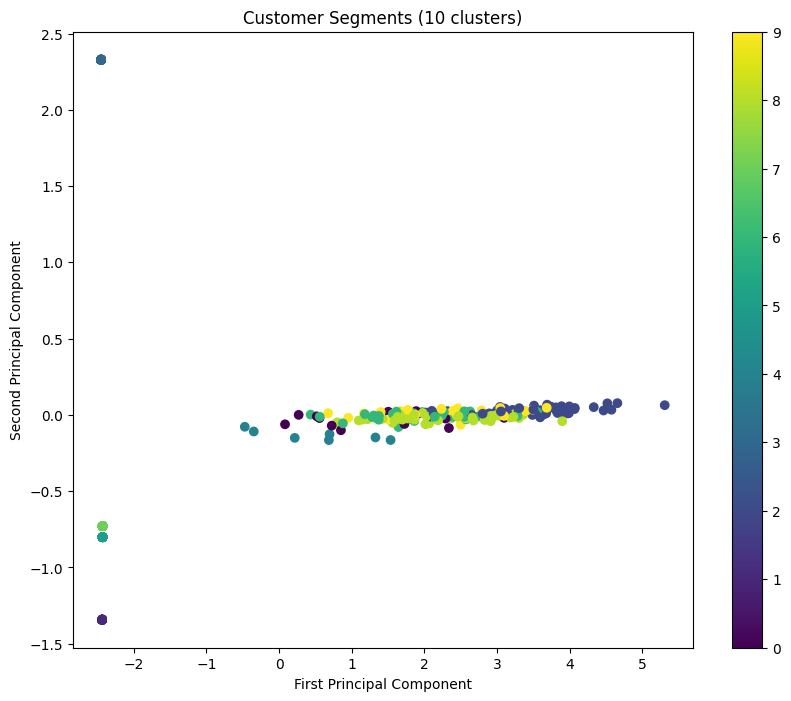

In [10]:
# Plot results
plot_clustering_metrics(metrics_df)
visualize_clusters(scaled_features, final_clusters, int(optimal_clusters))

In [11]:
# Analyze clusters
cluster_analysis = analyze_clusters(features_df, final_clusters, int(optimal_clusters))
print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
         transaction_count  total_spend  avg_transaction  recency
Cluster                                                          
0                     3.50      1879.58           541.40    97.55
1                     0.00         0.00             0.00     0.00
2                     7.49      5535.58           756.60    45.09
3                     0.00         0.00             0.00     0.00
4                     1.14       497.94           442.71   230.00
5                     0.00         0.00             0.00     0.00
6                     3.95      2654.71           697.57    83.05
7                     0.00         0.00             0.00     0.00
8                     4.65      3136.20           692.80    70.80
9                     4.27      2883.56           688.89    67.12


In [12]:
# Save cluster assignments
output_df = pd.DataFrame({
    'CustomerID': features_df.index,
    'Cluster': final_clusters
})
output_df.to_csv('customer_segments.csv', index=False)